# Transformers

## Overview

**This notebook implements Transformer model for HCP (movie watching) data**

Transformers were first present by Vaswani, et al. in their paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762).


---
## Data Organization
Same as in the [gru + attention](https://akshatyadav0.github.io/P_Lab_Works/attention_2.html) notebook

In [1]:
import torch
import pickle
import numpy as np
import torch.nn as nn

In [2]:
with open('Data/HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)
print(TS.keys())

dict_keys(['testretest', 'twomen', 'bridgeville', 'pockets', 'overcome', 'inception', 'socialnet', 'oceans', 'flower', 'hotel', 'garden', 'dreary', 'homealone', 'brokovich', 'starwars'])


In [3]:
rel = {}
l = 0
for movie_name, ts in TS.items():
    rel[movie_name] = l
    l += 1
    print(movie_name, ts.shape)

testretest (4, 176, 84, 300)
twomen (176, 245, 300)
bridgeville (176, 222, 300)
pockets (176, 189, 300)
overcome (176, 65, 300)
inception (176, 227, 300)
socialnet (176, 260, 300)
oceans (176, 250, 300)
flower (176, 181, 300)
hotel (176, 186, 300)
garden (176, 205, 300)
dreary (176, 143, 300)
homealone (176, 233, 300)
brokovich (176, 231, 300)
starwars (176, 256, 300)


In [4]:
train_feature = []
test_feature  = []
train_target  = []
test_target   = []
seq_length    = 198

for movie_name, ts in TS.items():
    pep = 0
    if movie_name != "testretest":
        for i in ts:
            pep += 1
            if (pep <= 100):
                if i.shape[0]>seq_length:
                    k = i[:seq_length][:]
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                    
                    k = i[i.shape[0]-seq_length:][:]
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                
                elif i.shape[0]<seq_length:
                    k = [[0]*300]*seq_length
                    k[seq_length-i.shape[0]:] = i
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                else:
                    train_feature.append(i)
                    train_target.append(rel[movie_name])

            else:
                if i.shape[0]>seq_length:
                    k = i[:seq_length][:]
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                   
                    k = i[i.shape[0]-seq_length:][:]
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                
                elif i.shape[0]<seq_length:
                    k = [[0]*300]*seq_length
                    k[seq_length-i.shape[0]:] = i
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                else:
                    test_feature.append(i)
                    test_target.append(rel[movie_name])
        print(pep)
    else:
        for jj in ts:
            pep = 0
            for i in jj:
                pep += 1
                if (pep <= 101):
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        train_feature.append(k)
                        train_target.append(rel[movie_name])

                        k = i[i.shape[0]-seq_length:][:]
                        train_feature.append(k)
                        train_target.append(rel[movie_name])

                    elif i.shape[0]<seq_length:
                        k = [[0]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        train_feature.append(k)
                        train_target.append(rel[movie_name])
                    else:
                        train_feature.append(i)
                        train_target.append(rel[movie_name])

                else:
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        test_feature.append(k)
                        test_target.append(rel[movie_name])

                        k = i[i.shape[0]-seq_length:][:]
                        test_feature.append(k)
                        test_target.append(rel[movie_name])

                    elif i.shape[0]<seq_length:
                        k = [[0]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        test_feature.append(k)
                        test_target.append(rel[movie_name])
                    else:
                        test_feature.append(i)
                        test_target.append(rel[movie_name])
            print(pep)

176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176


In [5]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(np.array(train_feature)).float(),torch.from_numpy(np.array(train_target)).float())
test_data  = TensorDataset(torch.from_numpy(np.array(test_feature)).float(),torch.from_numpy(np.array(test_target)).float())

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 32
valid_data  = 0.25
t_train     = len(train_data)
data_no     = list(range(t_train))
np.random.shuffle(data_no)
split_no    = int(np.ceil(valid_data*t_train))
train,valid = data_no[split_no:],data_no[:split_no]

train_sampler = SubsetRandomSampler(train)
valid_sampler = SubsetRandomSampler(valid)

train_loader  = DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,drop_last=True)
valid_loader  = DataLoader(train_data,sampler=valid_sampler,batch_size=batch_size,drop_last=True)
test_loader   = DataLoader(test_data, batch_size=batch_size,shuffle = True)

In [7]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

## Modelling

### Positional Encodings
<img src = "po_enc.png">

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, seq_len):
        """
        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding, self).__init__()

        # same size with input matrix (for adding with input matrix)
        
        self.encoding = torch.zeros(seq_len, d_model, device=device)
        self.encoding.requires_grad = False

        pos = torch.arange(0, seq_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]         

### Self Attention
<img src = "scale_dot_product_attention.jpg">

In [9]:
class Attention(nn.Module):
    """
    q : current sequence
    k : every sequence to check relationship with Qeury
    v : every seq same with Key
    """

    def __init__(self):
        super(Attention, self).__init__()
        
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):     # [batch_size, head, length, d_tensor]
        
        batch_size, head, length, d_tensor = k.size()

        # 1. dot product Query with Key^T to compute similarity
        
        k_t = k.transpose(2, 3)
        score = (q @ k_t) / np.sqrt(d_tensor)  # scaled dot product

        # 2. Masking (opt)
        
        # 3. Softmax
        score = self.softmax(score)

        # 4. multiply with Value
        v = score @ v

        return v, score

### Multi Head Attention
<img src = "multi_head_attention.jpg">

In [10]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = Attention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v):
        
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v)#, mask=mask)
        
        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        # visualize attention map => may implement visualization
        
        return out

    def split(self, tensor):
        """
        split tensor by number of head

        :param tensor: [batch_size, length, d_model]
        :return: [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.size()

        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor).transpose(1, 2)

        return tensor

    def concat(self, tensor):
        """
        :param tensor: [batch_size, head, length, d_tensor]
        :return: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor

### Feed Forward

In [49]:
class FeedForward(nn.Module):
    def __init__(self, d_model, feed_fwd, dropout = 0.1):
        super().__init__() 
        
        self.l1 = nn.Linear(d_model, feed_fwd)
        self.l2 = nn.Linear(feed_fwd, d_model)
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.relu = nn.ReLU()
    def forward(self, x):
        
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

### Transformer Block

In [55]:
class TransformerBlock(nn.Module):
    
    def __init__(self, d_model,feed_fwd ,n_heads,drop_prob):
        super(TransformerBlock, self).__init__()
        
        """
        Args:
           embed_dim: dimension of the embedding
           n_heads: number of attention heads
        
        """
        
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        
        self.norm1 = nn.LayerNorm(d_model) 
        self.norm2 = nn.LayerNorm(d_model)
        
        self.feed_fwd = FeedForward(d_model=d_model, feed_fwd=feed_fwd, dropout=drop_prob)

        self.dropout1 = nn.Dropout(p=drop_prob)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self,x):#key,query,value):
        
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
        """
        
        # 1. compute self attention
        _x = x
        #print(x.shape)
        x = self.attention(q=x, k=x, v=x)
        
        # 2. add and norm
        x = self.norm1(x + _x)
        x = self.dropout1(x)
        
        # 3. feed forward network
        _x = x
        x = self.feed_fwd(x)
      
        # 4. add and norm
        x = self.norm2(x + _x)
        x = self.dropout2(x)
        
        return x

### Complied Model

In [56]:
class Transformer_Model(nn.Module):

    def __init__(self, d_model, feed_fwd, out_dim, n_layers, n_head, drop_prob):
        super(Transformer_Model, self).__init__()

        self.layers = nn.ModuleList([TransformerBlock(d_model, feed_fwd, n_head, drop_prob) for i in range(n_layers)])
        self.linear_out = nn.Linear(d_model,out_dim)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)#,x,x)

        x = self.linear_out(x)
    
        return x

## Training

In [70]:
def train(epochs,train_loader,net,valid_loader,optimzer,criterion,att=True):
    val_acc = []
    tr_acc = []
    
    clip = 3 # gradient clipping

    net.to(device)
    net.train()
    
    valid_loss_min = np.Inf 
    
    valid_losses = []
    train_losses = []
    
    for e in range(epochs):
        num_correct = 0
        train_loss = []
        valid_loss = []
        train_acc  = 0.0
        valid_acc  = 0.0 
        counter = 0
        for inputs, labels in train_loader:
            
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            net.zero_grad()

            output = net(inputs)[:, -1, :]
            #print(output[:, -1, :].shape)
            pred = torch.round(output.squeeze()) 
            
            top_value, top_index = torch.max(pred,1)
            
            correct_tensor = top_index.eq(labels.float().view_as(top_index))
            correct = np.squeeze(correct_tensor.to('cpu').numpy())
            num_correct += np.sum(correct)


            loss = criterion(output, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            train_loss.append(loss.item())
        tr_acc.append(num_correct/((len(train_loader)-1)*batch_size))

        acc = 0.0
        val_losses = []
        net.eval()
        num_correct = 0
        v_c = 0
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

            output= net(inputs)[:, -1, :]
            
            pred = torch.round(output.squeeze()) 
            top_value, top_index = torch.max(pred,1)
            correct_tensor = top_index.eq(labels.float().view_as(top_index))
            correct = np.squeeze(correct_tensor.to('cpu').numpy())
            num_correct += np.sum(correct)

            val_loss = criterion(output.squeeze(),labels)
            val_losses.append(val_loss.item())
            
            if val_loss.item() <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, val_loss.item()))
                best_epoch = e
                if att:
                    torch.save(net.state_dict(), 'Trns_Multi_Att.pt')
                else:
                    torch.save(net.state_dict(), 'Trns_Single_Att.pt')
                valid_loss_min = val_loss.item()

        net.train()
        valid_losses.append(np.mean(val_losses))
        train_losses.append(np.mean(train_loss))
        val_acc.append(num_correct/(len(valid_loader)*batch_size))
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e+1,epochs,np.mean(train_loss),np.mean(val_losses)))
    
    return train_losses,valid_losses,tr_acc,val_acc,best_epoch

In [68]:
epochs     = 100
d_model    = 300
feed_fwd   = 150
output_dim = 15
n_head     = 4
n_layers   = 2
drop_prob  = 0.0006
lr         = 0.001

### Multi-Head Attention (No PoE)

In [57]:
model = Transformer_Model(d_model, feed_fwd, output_dim, n_layers,n_head, drop_prob)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
model

Transformer_Model(
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (attention): Attention(
          (softmax): Softmax(dim=-1)
        )
        (w_q): Linear(in_features=300, out_features=300, bias=True)
        (w_k): Linear(in_features=300, out_features=300, bias=True)
        (w_v): Linear(in_features=300, out_features=300, bias=True)
        (w_concat): Linear(in_features=300, out_features=300, bias=True)
      )
      (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (feed_fwd): FeedForward(
        (l1): Linear(in_features=300, out_features=150, bias=True)
        (l2): Linear(in_features=150, out_features=300, bias=True)
        (dropout): Dropout(p=0.0006, inplace=False)
        (relu): ReLU()
      )
      (dropout1): Dropout(p=0.0006, inplace=False)
      (dropout2): Dropout(p=0.0006, inplace=False)
    )
    (1): TransformerBlock(
      

In [58]:
train_losses,valid_losses,tr_acc,val_acc,best_epoch = train(epochs,train_loader,model,valid_loader,optimizer,criterion)

Validation loss decreased (inf --> 0.419096).  Saving model ...
Validation loss decreased (0.419096 --> 0.348300).  Saving model ...
Validation loss decreased (0.348300 --> 0.271155).  Saving model ...
Epoch: 1/100 	Training Loss: 1.167421 	Validation Loss: 0.474327
Validation loss decreased (0.271155 --> 0.249879).  Saving model ...
Validation loss decreased (0.249879 --> 0.220638).  Saving model ...
Validation loss decreased (0.220638 --> 0.088878).  Saving model ...
Epoch: 2/100 	Training Loss: 0.273253 	Validation Loss: 0.288038
Validation loss decreased (0.088878 --> 0.074936).  Saving model ...
Validation loss decreased (0.074936 --> 0.063233).  Saving model ...
Validation loss decreased (0.063233 --> 0.023823).  Saving model ...
Epoch: 3/100 	Training Loss: 0.115287 	Validation Loss: 0.280523
Validation loss decreased (0.023823 --> 0.018158).  Saving model ...
Validation loss decreased (0.018158 --> 0.014297).  Saving model ...
Epoch: 4/100 	Training Loss: 0.053292 	Validation L

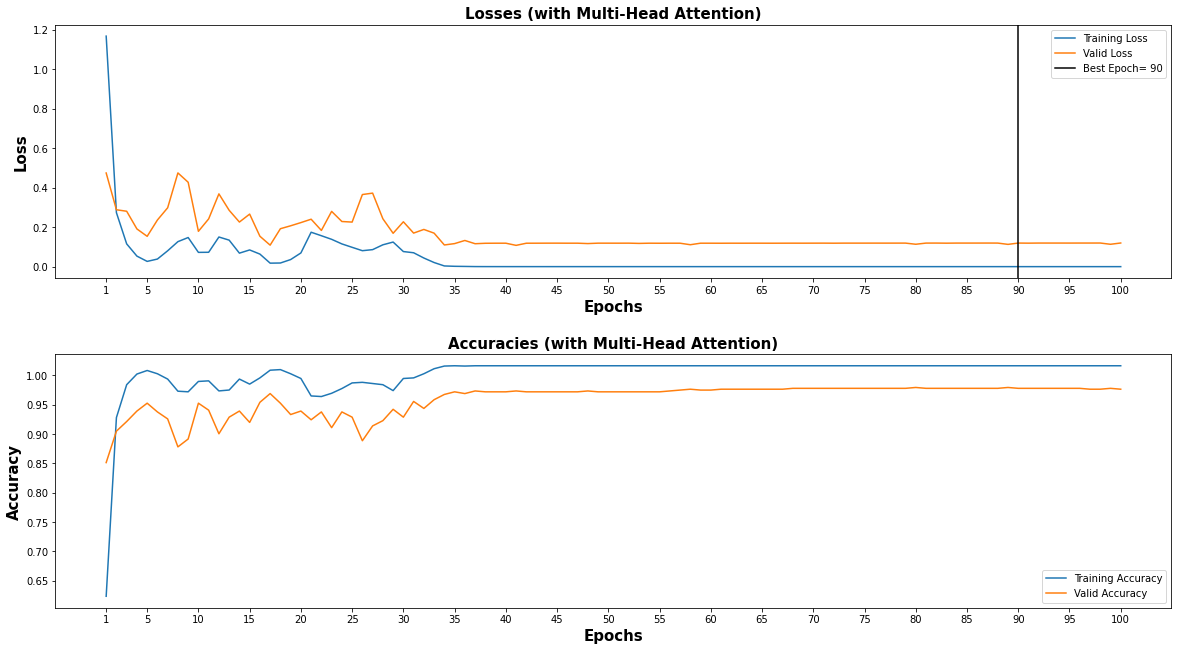

In [59]:
import matplotlib.pyplot as plt
x     = [i for i in range(1,epochs+1)]
xi    = [i for i in range(0,epochs+5,5)]
xi[0] = 1
f, axis = plt.subplots(2,1)
f.set_figwidth(20)
f.set_figheight(12)
plt.subplots_adjust(top=0.8, wspace=0.2,hspace=0.3)

axis[0].plot(x,train_losses)
axis[0].plot(x,valid_losses)
axis[0].axvline(best_epoch, color='black')
axis[0].set_xticks(xi)
axis[0].set_xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].set_ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].set_title("Losses (with Multi-Head Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch}"])


axis[1].plot(x,tr_acc)
axis[1].plot(x,val_acc)
axis[1].set_xticks(xi)
axis[1].set_xlabel("Epochs", fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].set_ylabel("Accuracy",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].set_title("Accuracies (with Multi-Head Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].legend(["Training Accuracy","Valid Accuracy"]);

### Single-Head Attention (No PoE)

In [69]:
n_head = 1
model  = Transformer_Model(d_model, feed_fwd, output_dim, n_layers,n_head, drop_prob)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
model

Transformer_Model(
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (attention): Attention(
          (softmax): Softmax(dim=-1)
        )
        (w_q): Linear(in_features=300, out_features=300, bias=True)
        (w_k): Linear(in_features=300, out_features=300, bias=True)
        (w_v): Linear(in_features=300, out_features=300, bias=True)
        (w_concat): Linear(in_features=300, out_features=300, bias=True)
      )
      (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (feed_fwd): FeedForward(
        (l1): Linear(in_features=300, out_features=150, bias=True)
        (l2): Linear(in_features=150, out_features=300, bias=True)
        (dropout): Dropout(p=0.0006, inplace=False)
        (relu): ReLU()
      )
      (dropout1): Dropout(p=0.0006, inplace=False)
      (dropout2): Dropout(p=0.0006, inplace=False)
    )
    (1): TransformerBlock(
      

In [71]:
train_losses,valid_losses,tr_acc,val_acc,best_epoch = train(epochs,train_loader,model,valid_loader,optimizer,criterion,att=False)

Validation loss decreased (inf --> 0.391958).  Saving model ...
Validation loss decreased (0.391958 --> 0.238264).  Saving model ...
Epoch: 1/100 	Training Loss: 1.175492 	Validation Loss: 0.596091
Validation loss decreased (0.238264 --> 0.233604).  Saving model ...
Validation loss decreased (0.233604 --> 0.167538).  Saving model ...
Epoch: 2/100 	Training Loss: 0.354066 	Validation Loss: 0.460645
Validation loss decreased (0.167538 --> 0.151649).  Saving model ...
Validation loss decreased (0.151649 --> 0.124948).  Saving model ...
Validation loss decreased (0.124948 --> 0.086300).  Saving model ...
Epoch: 3/100 	Training Loss: 0.219174 	Validation Loss: 0.269185
Validation loss decreased (0.086300 --> 0.039770).  Saving model ...
Epoch: 4/100 	Training Loss: 0.102423 	Validation Loss: 0.270010
Epoch: 5/100 	Training Loss: 0.086554 	Validation Loss: 0.301405
Validation loss decreased (0.039770 --> 0.039577).  Saving model ...
Epoch: 6/100 	Training Loss: 0.086857 	Validation Loss: 0.2

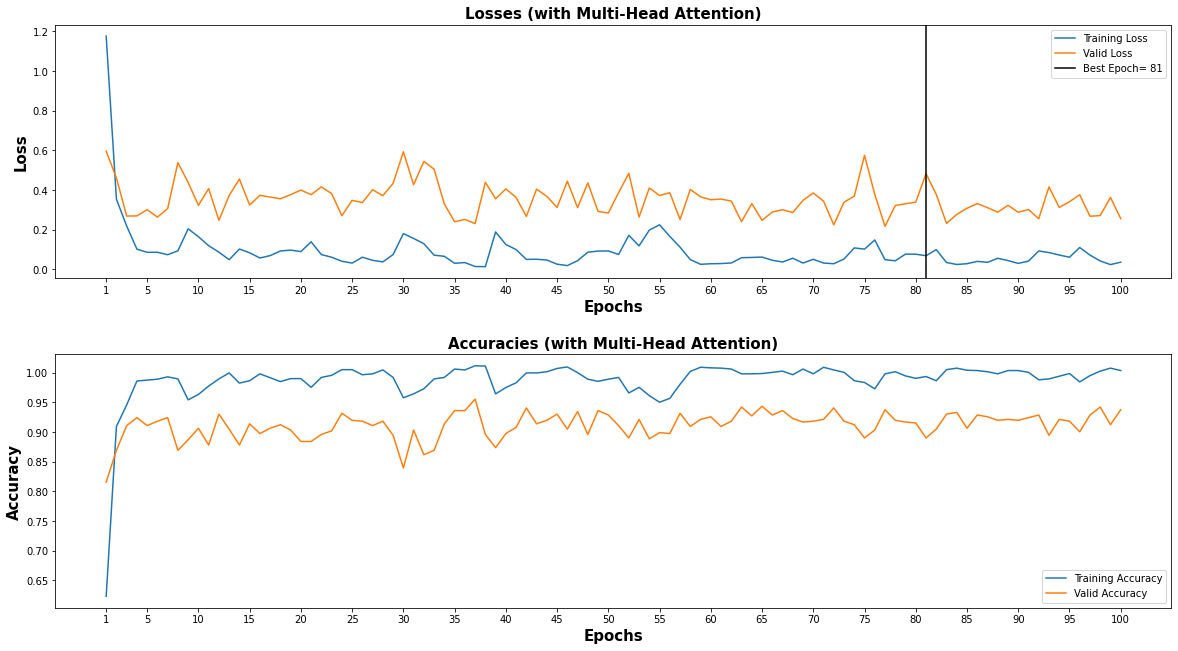

In [72]:
x     = [i for i in range(1,epochs+1)]
xi    = [i for i in range(0,epochs+5,5)]
xi[0] = 1
f, axis = plt.subplots(2,1)
f.set_figwidth(20)
f.set_figheight(12)
plt.subplots_adjust(top=0.8, wspace=0.2,hspace=0.3)

axis[0].plot(x,train_losses)
axis[0].plot(x,valid_losses)
axis[0].axvline(best_epoch, color='black')
axis[0].set_xticks(xi)
axis[0].set_xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].set_ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].set_title("Losses (with 1-Head Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch}"])


axis[1].plot(x,tr_acc)
axis[1].plot(x,val_acc)
axis[1].set_xticks(xi)
axis[1].set_xlabel("Epochs", fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].set_ylabel("Accuracy",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].set_title("Accuracies (with 1-Head Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].legend(["Training Accuracy","Valid Accuracy"]);

## Testing

In [60]:
def test(test_loader,net):
    net.to(device)
    net.eval()
    num_correct = 0
    valid_acc = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
        
        output = net(inputs)[:,-1,:]

        pred = torch.round(output.squeeze()) 
        top_value, top_index = torch.max(pred,1)
        correct_tensor = top_index.eq(labels.float().view_as(top_index))
        correct = np.squeeze(correct_tensor.to('cpu').numpy())
        num_correct += np.sum(correct)
    
    test_acc = num_correct/((len(test_loader)-1)*batch_size)
    print("Test accuracy: {:.3f} %".format(test_acc*100))

### Multi-Head Attention (No PoE)

In [62]:
model = Transformer_Model(d_model, feed_fwd, output_dim, n_layers, n_head, drop_prob)
model.load_state_dict(torch.load('Trns_Multi_Att.pt'))

<All keys matched successfully>

In [63]:
test(test_loader,model)

Test accuracy: 98.214 %


### Single-Head Attention (No PoE)

In [73]:
model = Transformer_Model(d_model, feed_fwd, output_dim, n_layers, n_head, drop_prob)
model.load_state_dict(torch.load('Trns_Single_Att.pt'))

<All keys matched successfully>

In [74]:
test(test_loader,model)

Test accuracy: 93.105 %
